# Backbone Feature Detector - Darknet53
This will be an implementation of the backbonepart of Yolov3. The various comment will guide you into the code, but for a more general understanding of the project i suggest to read the README.md

## Importing the main libraries

In [62]:
# Utility libraries
import os
import random
import matplotlib.pyplot as plt
import cv2

# Core libraries
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Softmax
# from tensorflow.keras import regularizers
# from tensorflow.keras import metrics
# from tensorflow.keras import losses
# from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
# from tensorflow.keras.layers import Conv2D, LeakyReLU, Add, BatchNormalization, GlobalAveragePooling2D, Dense, Softmax


In [3]:
# Load the TensorBoard notebook extension (for visualization purposes)
%load_ext tensorboard

## Model designing

### Residual Blocks
First of all, we need to write down the code for the residual blocks used in the Darknet-53, which is a 53 layer deep feature extracotr used as a backbone for YOLOv3.

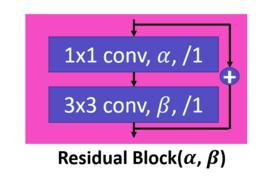

In [56]:
from tensorflow.keras.layers import Conv2D, LeakyReLU, Add, BatchNormalization, GlobalAveragePooling2D, Dense, Softmax


class Conv_2D_plus(keras.Model):
    def __init__(self, filters, kernel_size, stride = 1, shape = None, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.stride = stride
    
    def call(self, inputs):
        X = Conv2D(filters = self.filters,
                   kernel_size = self.kernel_size,
                   strides = self.stride,
                   padding = "same",
                   use_bias = False)(inputs)
        X = BatchNormalization()(X)
        X = LeakyReLU(alpha=0.1)(X)
        return X


class Residual_Block(keras.Model):
    def __init__(self, filters_alpha, filters_beta, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = Conv_2D_plus(filters_alpha, 1)
        self.hidden2 = Conv_2D_plus(filters_beta, 3)
        self.hidden = [self.hidden1, self.hidden2]
        
    def call(self, inputs):
        Z = inputs
        skip_Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        output = Add()([Z, skip_Z])
        return output


## Defining the model itself

In [87]:
class Darknet53(keras.Model):
    def __init__ (self, classification = False, num_classes = None, shape=(32, 1920, 1080, 3), **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.classification = classification
        self.pre_conv = Conv_2D_plus(32, 3, shape=shape[1:])
        self.conv_res = [self.Darknet_res_block(64, 1),
                          self.Darknet_res_block(128, 2),
                          self.Darknet_res_block(256, 8),
                          self.Darknet_res_block(512, 8),
                          self.Darknet_res_block(1024, 4)]
        if self.classification:
            self.out1 = GlobalAveragePooling2D()
            self.out2 = Dense(self.num_classes)
            self.out3 = Softmax()
        
    def call(self, inputs):
        Y = inputs
        Y = self.pre_conv(Y)
        for res_block in self.conv_res:
            for layer in res_block:
                Y = layer(Y)
        if self.classification:
            Y = self.out1(Y)
            Y = tf.reshape(Y, (1,1,1,1024))
            Y = self.out2(Y)
            Y = self.out3(Y)
        return Y
    
    def Darknet_res_block(self, num_filters, num_blocks):
        layers = [Conv_2D_plus(num_filters, 3, stride = 2)]
        for i in range(num_blocks):
            layers.append(Residual_Block(num_filters // 2, num_filters))
        return layers
    

input_shape=(1, 452, 602, 3)
model = Darknet53(classification = True, num_classes = 3)
model.build(input_shape)

def get_test_input():

    img_ = tf.io.read_file("dog-cycle-car.png")
    img_ = tf.image.decode_png(img_, channels=3)
    img_ = tf.image.convert_image_dtype(img_, dtype=tf.float32)
    img_ = tf.reshape(img_, (1, 452, 602, 3))
    print(img_)
    return img_

inp = get_test_input()
pred = model.predict(inp)
print(pred)


tf.Tensor(
[[[[0.2392157  0.2392157  0.22352943]
   [0.2392157  0.2392157  0.22352943]
   [0.2392157  0.2392157  0.22352943]
   ...
   [0.6666667  0.7019608  0.43921572]
   [0.28235295 0.29411766 0.10980393]
   [0.25882354 0.25882354 0.1137255 ]]

  [[0.2392157  0.2392157  0.22352943]
   [0.2392157  0.2392157  0.22352943]
   [0.2392157  0.2392157  0.22352943]
   ...
   [0.6039216  0.63529414 0.38431376]
   [0.23529413 0.24705884 0.07450981]
   [0.23529413 0.227451   0.09411766]]

  [[0.2392157  0.2392157  0.22352943]
   [0.2392157  0.2392157  0.22352943]
   [0.2392157  0.2392157  0.22352943]
   ...
   [0.49803925 0.5254902  0.3019608 ]
   [0.19607845 0.20392159 0.03921569]
   [0.25882354 0.25490198 0.12941177]]

  ...

  [[0.627451   0.6627451  0.7137255 ]
   [0.627451   0.6627451  0.7137255 ]
   [0.627451   0.6627451  0.7137255 ]
   ...
   [0.4431373  0.427451   0.41176474]
   [0.2509804  0.23529413 0.22352943]
   [0.21176472 0.19607845 0.18431373]]

  [[0.627451   0.6627451  0.713725

ValueError: in user code:

    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    <ipython-input-85-66a4a5a47ec1>:19 call  *
        Y = self.pre_conv(Y)
    <ipython-input-56-d82fc63c0c8a>:20 call  *
        X = Conv2D(filters = self.filters,
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:982 __call__  **
        self._maybe_build(inputs)
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2643 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/keras/layers/convolutional.py:197 build
        self.kernel = self.add_weight(
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:597 add_weight
        variable = self._add_variable_with_custom_getter(
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/training/tracking/base.py:745 _add_variable_with_custom_getter
        new_variable = getter(
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_utils.py:133 make_variable
        return tf_variables.VariableV1(
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:260 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:206 _variable_v1_call
        return previous_getter(
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2857 creator
        return next_creator(**kwargs)
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2857 creator
        return next_creator(**kwargs)
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2857 creator
        return next_creator(**kwargs)
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/andrea/anaconda2/envs/ai/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py:701 invalid_creator_scope
        raise ValueError(

    ValueError: tf.function-decorated function tried to create variables on non-first call.


## Loading weights
This doesn't seems like it's working, it's ok if you look at https://arxiv.org/pdf/1811.08883.pdf

In [48]:
from pathlib import Path
weights_path = Path('/home/andrea/AI/ispr_yolo/weights/darknet_pretrained')
fp = weights_path.joinpath('darknet53.weights')
# header = np.fromfile(fp, dtype = np.int32, count = 5)
#print(header)
weights = np.fromfile(fp, dtype = np.float32, offset=160)
print(weights.shape)





(40620605,)
